In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d emineyetm/fake-news-detection-datasets

Dataset URL: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
License(s): unknown
 93% 38.0M/41.0M [00:00<00:00, 93.9MB/s]
100% 41.0M/41.0M [00:00<00:00, 76.6MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fake-news-detection-datasets.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score

In [5]:
fake = pd.read_csv('/content/News _dataset/Fake.csv')
real = pd.read_csv('/content/News _dataset/True.csv')

In [6]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake.subject.value_counts()

,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


In [9]:
unknown_publisher = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1]
    assert(len(record[0]) < 120)
  except:
    unknown_publisher.append(index)

In [10]:
len(unknown_publisher)

222

In [11]:
real.iloc[unknown_publisher].text

,text
7,The following statements were posted to the ve...
8,The following statements were posted to the ve...
12,The following statements were posted to the ve...
13,The following statements were posted to the ve...
14,"(In Dec. 25 story, in second paragraph, corre..."
...,...
20135,(Story corrects to million from billion in pa...
20500,"(This Sept 8 story corrects headline, clarifi..."
20667,"(Story refiles to add dropped word not , in ..."
21246,(Story corrects third paragraph to show Mosul...


In [12]:
real.drop(8970, axis = 0)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [13]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publisher:
    tmp_text.append(row)
    publisher.append('Unknown')
  else:
    record = row.split('-', maxsplit = 1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [14]:
real['publisher'] = publisher
real['text'] = tmp_text

In [15]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [16]:
real.shape

(21417, 5)

In [17]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip() == ""]

In [18]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [19]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [20]:
real['text'] = real['text'].apply(lambda x : str(x).lower())
fake['text'] = fake['text'].apply(lambda x : str(x).lower())

In [21]:
real['class'] = 1
fake['class'] = 0

In [22]:
real = real[['text', 'class']]

In [23]:
fake = fake[['text', 'class']]

In [24]:
real

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
21412,'fully committed' nato backs new u.s. approach...,1
21413,lexisnexis withdrew two products from chinese ...,1
21414,minsk cultural hub becomes haven from authorit...,1
21415,vatican upbeat on possibility of pope francis ...,1


In [25]:
real

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
21412,'fully committed' nato backs new u.s. approach...,1
21413,lexisnexis withdrew two products from chinese ...,1
21414,minsk cultural hub becomes haven from authorit...,1
21415,vatican upbeat on possibility of pope francis ...,1


In [26]:
data = pd.concat([real, fake], ignore_index=True)

In [27]:
data.sample(5)

,text,class
37649,world famous designer tells americans to “deal...,0
222,"exclusive: contenders emerge for no.2 fed job,...",1
23162,breaking: explosive russian dossier deemed re...,0
35970,“get angry”: how obama’s “purple army” is team...,0
15247,u.n. watchdog says australia must change its m...,1


In [28]:
# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    # text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

In [29]:
# Clean the text data
data['text'] = data['text'].apply(clean_text)

In [30]:
data

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1
...,...,...
44893,mcpain john mccain furious that iran treated u...,0
44894,justice yahoo settles email privacy classactio...,0
44895,sunnistan us and allied ‘safe zone’ plan to ta...,0
44896,how to blow million al jazeera america finall...,0


In [31]:
import gensim

In [32]:
y = data['class'].values

In [33]:
X = [d.split() for d in data['text'].tolist()]

In [34]:
type(X)

list

In [35]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', '“fiscal', 'conservative”', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs’', '“face', 'the', 'nation”', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues', 's

In [36]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [37]:
len(w2v_model.wv.key_to_index)

225711

In [38]:
w2v_model.wv.key_to_index

{'the': 0,
 'to': 1,
 'of': 2,
 'a': 3,
 'and': 4,
 'in': 5,
 'that': 6,
 'on': 7,
 'for': 8,
 's': 9,
 'is': 10,
 'he': 11,
 'said': 12,
 'trump': 13,
 'it': 14,
 'with': 15,
 'was': 16,
 'as': 17,
 'his': 18,
 'by': 19,
 'has': 20,
 'be': 21,
 'have': 22,
 'not': 23,
 'from': 24,
 'at': 25,
 'this': 26,
 'are': 27,
 'who': 28,
 'us': 29,
 'an': 30,
 'they': 31,
 'but': 32,
 'would': 33,
 'we': 34,
 'i': 35,
 'president': 36,
 'about': 37,
 'will': 38,
 'their': 39,
 'had': 40,
 'you': 41,
 't': 42,
 'been': 43,
 'people': 44,
 'were': 45,
 'or': 46,
 'more': 47,
 'after': 48,
 'which': 49,
 'she': 50,
 'her': 51,
 'one': 52,
 'out': 53,
 'if': 54,
 'all': 55,
 'what': 56,
 'state': 57,
 'when': 58,
 'new': 59,
 'its': 60,
 'also': 61,
 'up': 62,
 'over': 63,
 'no': 64,
 'there': 65,
 'house': 66,
 'donald': 67,
 'our': 68,
 'clinton': 69,
 'obama': 70,
 'government': 71,
 'can': 72,
 'just': 73,
 'states': 74,
 'him': 75,
 'than': 76,
 'republican': 77,
 'so': 78,
 'other': 79,
 'som

In [39]:
w2v_model.wv.most_similar('china')

[('beijing', 0.8654593825340271),
 ('taiwan', 0.810299277305603),
 ('china’s', 0.7422122359275818),
 ('chinese', 0.6960458159446716),
 ('japan', 0.6937278509140015),
 ('china”', 0.6823362112045288),
 ('pyongyang', 0.6724692583084106),
 ('india', 0.668049693107605),
 ('xi', 0.6453114151954651),
 ('waterway', 0.6388210654258728)]

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [41]:
X = tokenizer.texts_to_sequences(X)

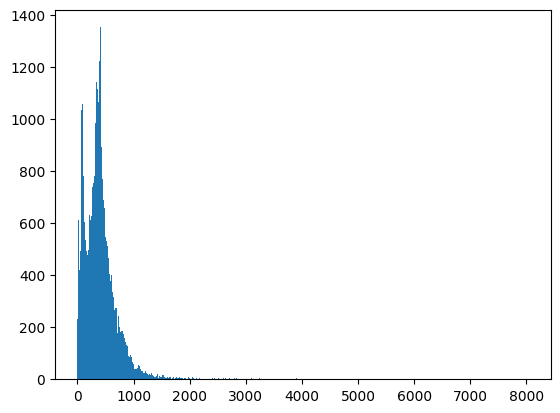

In [42]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [43]:
nos = np.array([len(x) for x in X])
len(nos[nos > 1000])

1512

In [44]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [45]:
len(X[1])

1000

In [46]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [47]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [48]:
embedding_vectors = get_weight_matrix(w2v_model)

In [49]:
embedding_vectors.shape

(225712, 100)

In [50]:
model = Sequential()
model.add(Embedding(vocab_size, DIM,weights=[embedding_vectors], input_length=maxlen))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      22,571,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,571,200 (86.10 MB)

 Trainable params: 22,571,200 (86.10 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [52]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - acc: 0.9197 - loss: 0.2049 - val_acc: 0.9702 - val_loss: 0.0898
Epoch 2/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - acc: 0.9826 - loss: 0.0544 - val_acc: 0.9873 - val_loss: 0.0384
Epoch 3/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - acc: 0.9933 - loss: 0.0228 - val_acc: 0.9863 - val_loss: 0.0421
Epoch 4/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - acc: 0.9962 - loss: 0.0143 - val_acc: 0.9894 - val_loss: 0.0374
Epoch 5/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - acc: 0.9984 - loss: 0.0064 - val_acc: 0.9922 - val_loss: 0.0257
Epoch 6/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - acc: 0.9987 - loss: 0.0046 - val_acc: 0.9920 - val_loss: 0.0228


In [53]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [54]:
accuracy_score(y_test, y_pred)

0.9939420935412027

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5913
           1       0.99      1.00      0.99      5312

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



#**Prediction**

In [56]:
x = ['This is a news']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [57]:
(model.predict(x) >= 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


array([[0]])

In [58]:
test = ['Sudan and South Sudan have been facing multiple and severe difficulties over the past decades, with people suffering from the devastating impact of armed conflict and harsh environmental conditions such as severe flooding and drought, including the Horn of Africa drought. These crises have led to death, disease and displacement for millions. WHO is working hard with governments and donors to protect and support the health and well-being of extremely vulnerable populations.']

In [59]:
test = tokenizer.texts_to_sequences(test)
test = pad_sequences(test, maxlen=maxlen)

In [60]:
(model.predict(test) >= 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[1]])

In [61]:
from tensorflow.keras.models import Model

In [62]:
# Save the model to an HDF5 file
model.save('/content/fake_news_detection.h5')

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

In [64]:
tokenizer_path = '/content/tokenizer.pkl'
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)